# Auction exercise

We participate in auctions for items characterized by x. In these auctions  each potential buyer must place a single bid, unaware of competitors' bids. The item is awarded to the highest bidder at the price offered. In other words, if we place a bid z and win the auction our costs are equal to z.

The outcomes from the auctions participated are provided in an aggregated format per item. The attached file provides the raw data for a set of auctions participated.

Objectives:
1. Develop a model to predict the probability of winning an auction based on our bid and the item feature x. If you can think of a way, the model should ideally also be able to predict the confidence of predictions.
2. Derive the probability density function for the winning bid for x=3. What is the probability that the winning bid lies between 1 and 2?
3. Let’s assume that we participate again on an identical set of auctions with the same bids as in the provided dataset. Based on your model, what is the probability of observing costs larger than in the provided dataset?

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import sklearn.metrics as sk_m

from sklearn.metrics import confusion_matrix, auc, roc_curve, RocCurveDisplay
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from scipy.stats import gaussian_kde, uniform

In [2]:
random_state = 7
rgn = np.random.default_rng(random_state)

In [3]:
def plot_scores(y_true, y_pred, n_classe:int=2, classe_name=None, modelname='') :
    """
    Arguments :
    Plot the confusion Matrix and different scores
    y_true (array) : Ground truth (correct) target values.
    y_pred (array) :Estimated targets as returned by a classifier.
    """
    N_test = len(y_pred)
    cm = sk_m.confusion_matrix(y_true, y_pred)
    cm_bis = cm.flatten()
    
    if n_classe == 2 :
        group_names = ['True Neg','False Pos','False Neg','True Pos']
        group_counts = [f"{v : 0.0f}" for v in cm_bis]
        group_percentages = ['{0:.2%}'.format(value) for value in cm_bis/N_test]
        labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
        labels = np.asarray(labels).reshape(2,2)
    else :
        group_counts = [f"{v : 0.0f}" for v in cm_bis]
        group_percentages = ['{0:.2%}'.format(value) for value in cm_bis/N_test]
        for i in range(n_classe**2) :
            if int(group_counts[i]) == 0 :
                group_counts[i], group_percentages[i]= '', ''
        labels = [f'{v1}\n{v2}\n' for v1, v2 in zip(group_counts,group_percentages)]
        labels = np.asarray(labels).reshape(n_classe, n_classe)
    
    if classe_name is None :
        classe_name = list(range(n_classe))
        
    plt.figure(figsize=(9, 6))
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', xticklabels=classe_name, yticklabels=classe_name)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()
    
    print(f"Classification report of the model for this testing set")
    print(sk_m.classification_report(y_true, y_pred, digits=3))
    acc_score = sk_m.accuracy_score(y_true, y_pred)
    print('-'*55 + '\n')

## Data preparation

We consider that:
- `x` is the param of the item
- `bid` is the bid we make for this `x`
- `auctions` is the number of auctions we participate with `(x,bid)`
- `wins` is the number of wins we made over `auctions` with `(x,bid)`

In [4]:
df_data = pd.read_csv("auctions_summary.csv", delimiter=',')
df_data["losses"] = df_data["auctions"] - df_data["wins"]
df_data["wins_ratio"] = df_data["wins"] / df_data["auctions"]
df_data.describe()

,x,bid,auctions,wins,losses,wins_ratio
count,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000
mean,2.866859,1.581527,5.093069,2.190099,2.902970,0.417230
std,1.747467,1.554054,2.224782,2.727633,2.808097,0.454676
min,0.028227,-1.680578,1.000000,0.000000,-3.000000,0.000000
25%,1.256365,0.384293,3.000000,0.000000,0.000000,0.000000
50%,2.862625,0.944562,5.000000,1.000000,3.000000,0.166667
75%,4.394171,2.421456,6.000000,4.000000,5.000000,1.000000
max,5.984624,5.837404,12.000000,12.000000,12.000000,1.500000


We assume that the bid is positive, and that we can't win more time that we've participated auctions for a given `(x,bid)`

In [5]:
df_data = df_data[(df_data["bid"] >= 0) & (df_data["wins_ratio"] <= 1)]

In [6]:
df_data.describe()

,x,bid,auctions,wins,losses,wins_ratio
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,2.856842,1.598030,5.098000,2.166000,2.932000,0.411617
std,1.747752,1.546013,2.228526,2.709451,2.796967,0.449939
min,0.028227,0.169887,1.000000,0.000000,0.000000,0.000000
25%,1.242002,0.392008,3.000000,0.000000,0.000000,0.000000
50%,2.860087,0.958994,5.000000,1.000000,3.000000,0.166667
75%,4.391381,2.433355,6.250000,4.000000,5.000000,1.000000
max,5.984624,5.837404,12.000000,12.000000,12.000000,1.000000


## Data visualization

In [7]:
print(f"Ratio of number of auctions win: {df_data['wins'].sum()/df_data['auctions'].sum():.2%}")

Ratio of number of auctions win: 42.49%


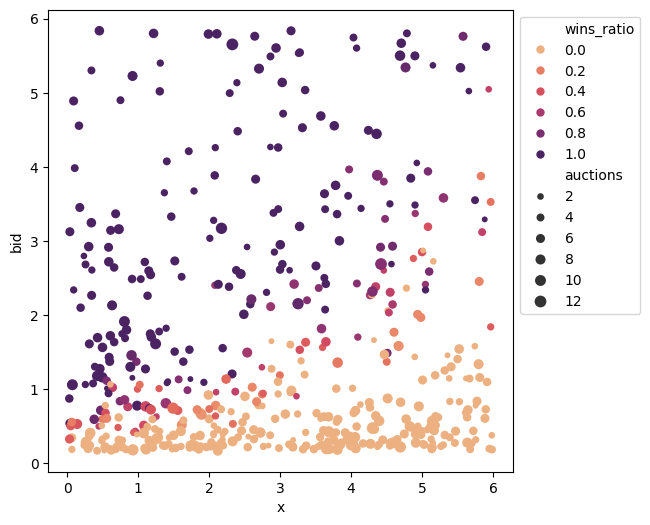

In [8]:
fig, ax = plt.subplots(figsize=(6, 6))
# sns.despine(f, left=True, bottom=True)
sns.scatterplot(
    x="x", y="bid", hue="wins_ratio", size="auctions",
    palette="flare", linewidth=0, data=df_data, ax=ax
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

Data are not well reparted, we don't have a lot with high bid

### Data split

In [9]:
df_data.loc[:, ["win"]] = df_data.loc[:, ["wins", "losses"]].apply(lambda s: [0]*s['losses'] + [1]*s['wins'], axis=1)
df_data_expanded = df_data.explode("win", ignore_index=True)\
    .astype({"win": int})\
    .sample(frac=1)
df_data_expanded.describe()

,x,bid,auctions,wins,losses,wins_ratio,win
count,2549.000000,2549.000000,2549.000000,2549.000000,2549.000000,2549.000000,2549.000000
mean,2.811986,1.614155,6.070224,2.604943,3.465281,0.424872,0.424872
std,1.732706,1.574560,2.226255,3.076802,3.181961,0.451324,0.494421
min,0.028227,0.169887,1.000000,0.000000,0.000000,0.000000,0.000000
25%,1.178089,0.407546,4.000000,0.000000,0.000000,0.000000,0.000000
50%,2.807454,0.932589,6.000000,1.000000,3.000000,0.200000,0.000000
75%,4.346854,2.426483,7.000000,5.000000,6.000000,1.000000,1.000000
max,5.984624,5.837404,12.000000,12.000000,12.000000,1.000000,1.000000


### Data distribution

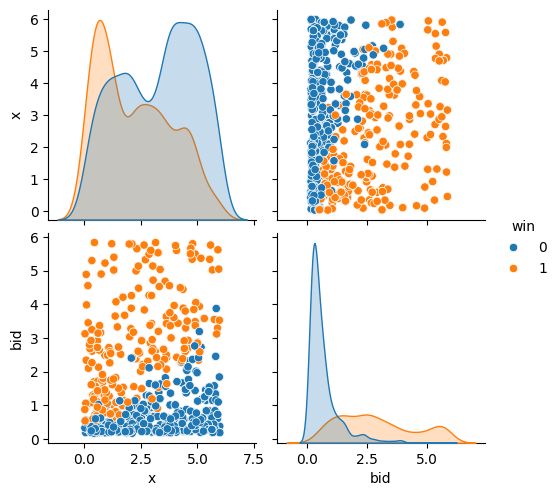

In [10]:
sns.pairplot(
    df_data_expanded, hue="win", vars=("x", "bid")
)

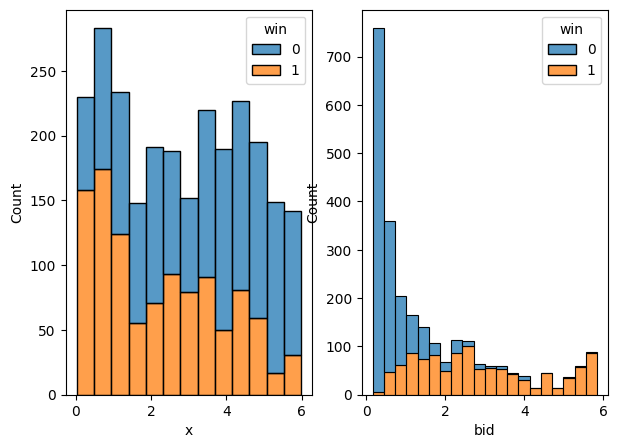

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(7, 5))

sns.histplot(
    df_data_expanded, x="x", hue="win",
    multiple="stack", ax=axs[0]
)
sns.histplot(
    df_data_expanded, x="bid", hue="win",
    multiple="stack", ax=axs[1]
)
plt.show()

The data are not following a gaussian distribution

## Training and exploration

We assume that the result of the auctions are independent from the others. The bids are also independent from each other.

In [12]:
X = df_data_expanded[["x", "bid"]].to_numpy()
y = df_data_expanded["win"].to_numpy()
n_data = len(y)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=random_state)

#### Data transformation

In [14]:
from sklearn import preprocessing

Yeo-Johnson or Box-Cox transformation

In [15]:
# pt = preprocessing.PowerTransformer(method='yeo-johnson', standardize=True)
pt = preprocessing.PowerTransformer(method='box-cox', standardize=True)
X_train_transform = pt.fit_transform(X_train)
X_val_transform = pt.transform(X_val)
X_test_transform = pt.transform(X_test)
X_transform = pt.transform(X)

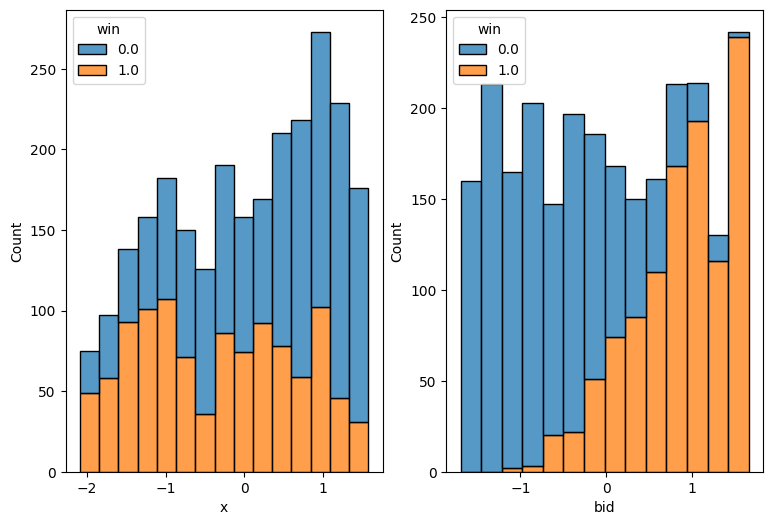

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(9, 6))
sns.histplot(
    pd.DataFrame(
        np.hstack((X_transform[:, 0, None], y[:, None])),
        columns=("x", "win")
    ), x="x", hue="win",
    multiple="stack", ax=axs[0]
)
sns.histplot(
    pd.DataFrame(
        np.hstack((X_transform[:, 1, None], y[:, None])),
        columns=("bid", "win")
    ), x="bid", hue="win",
    multiple="stack", ax=axs[1]
)
plt.show()

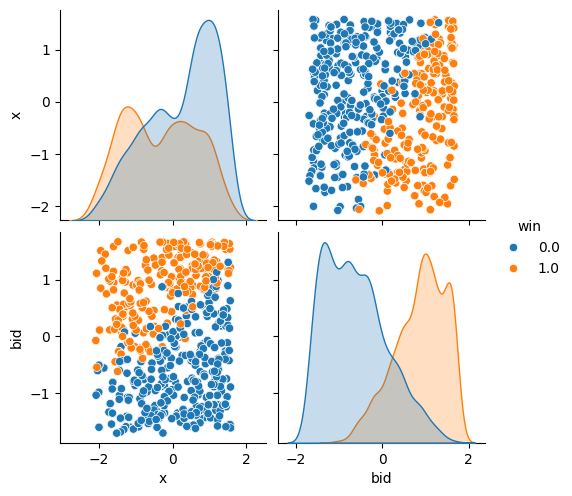

In [17]:
df_data_expanded_trans = pd.DataFrame(
    np.hstack((X_transform, y[:, None])),
    columns=("x", "bid", "win")
)

sns.pairplot(
    df_data_expanded_trans, hue="win", vars=("x", "bid")
)

Quantile distribution transformation

In [18]:
quantile_transformer = preprocessing.QuantileTransformer(
    output_distribution='normal', random_state=random_state
)
X_train_transform_qt = quantile_transformer.fit_transform(X_train)
X_val_transform_qt = quantile_transformer.transform(X_val)
X_test_transform_qt = quantile_transformer.transform(X_test)
X_transform_qt = quantile_transformer.transform(X)

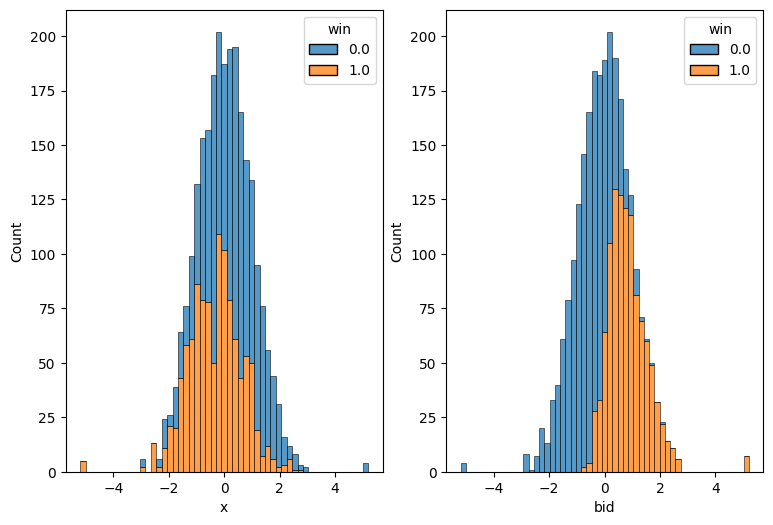

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(9, 6))
sns.histplot(
    pd.DataFrame(
        np.hstack((X_transform_qt[:, 0, None], y[:, None])),
        columns=("x", "win")
    ), x="x", hue="win",
    multiple="stack", ax=axs[0]
)
sns.histplot(
    pd.DataFrame(
        np.hstack((X_transform_qt[:, 1, None], y[:, None])),
        columns=("bid", "win")
    ), x="bid", hue="win",
    multiple="stack", ax=axs[1]
)
plt.show()

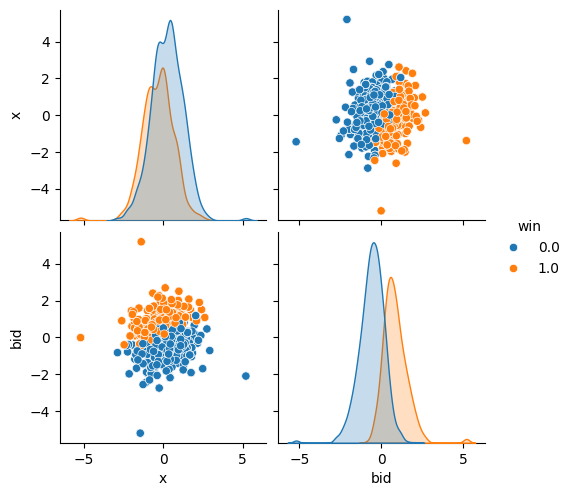

In [20]:
df_data_expanded_trans_qt = pd.DataFrame(
    np.hstack((X_transform_qt, y[:, None])),
    columns=("x", "bid", "win")
)

sns.pairplot(
    df_data_expanded_trans_qt, hue="win", vars=("x", "bid")
)

### Training

In [21]:
early_stopping = lgb.early_stopping(stopping_rounds=10)
kfold = StratifiedKFold(n_splits=10, random_state=random_state, shuffle=True)

Which model is the best using CV validation and basic training

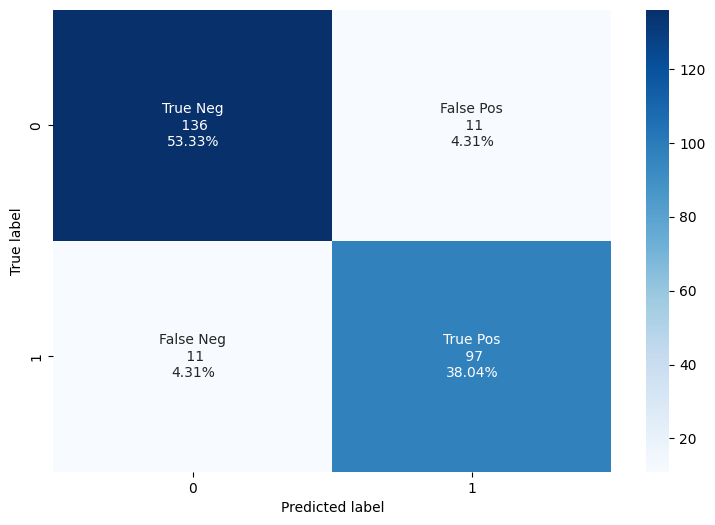

Classification report of the model for this testing set
              precision    recall  f1-score   support

           0      0.925     0.925     0.925       147
           1      0.898     0.898     0.898       108

    accuracy                          0.914       255
   macro avg      0.912     0.912     0.912       255
weighted avg      0.914     0.914     0.914       255

-------------------------------------------------------



In [22]:
from sklearn.linear_model import LogisticRegressionCV

lr_clf = LogisticRegressionCV(cv=10, max_iter=200, random_state=random_state)\
    .fit(X_train_transform, y_train)

y_pred = lr_clf.predict_proba(X_test_transform)
plot_scores(y_test, np.array([0 if x < 0.5 else 1 for x in y_pred[:, 1]]))

In [23]:
# LGBM Classifier without CV
lgbm_clf = lgb.LGBMClassifier(random_state=random_state)
lgbm_results = cross_val_score(lgbm_clf, X_train, y_train, cv=kfold)
print(f"\nAccuracy: {lgbm_results.mean():.2%} ({lgbm_results.std():.2%})")

[LightGBM] [Info] Number of positive: 772, number of negative: 1063
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000575 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 491
[LightGBM] [Info] Number of data points in the train set: 1835, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.420708 -> initscore=-0.319866
[LightGBM] [Info] Start training from score -0.319866
[LightGBM] [Info] Number of positive: 772, number of negative: 1063
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 493
[LightGBM] [Info] Number of data points in the train set: 1835, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.420708 -> initscore=-0.319866
[LightGBM] [In

[LightGBM] [Info] Number of positive: 857, number of negative: 1182
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 491
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.420304 -> initscore=-0.321525
[LightGBM] [Info] Start training from score -0.321525
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[42]	valid_0's binary_logloss: 0.23259


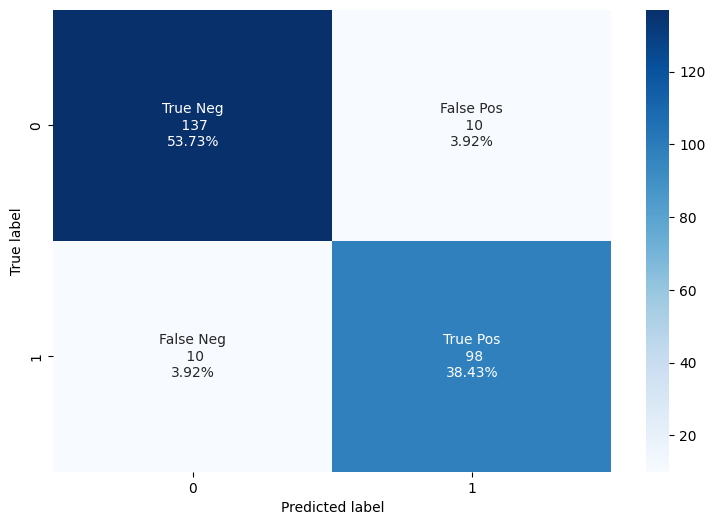

Classification report of the model for this testing set
              precision    recall  f1-score   support

           0      0.932     0.932     0.932       147
           1      0.907     0.907     0.907       108

    accuracy                          0.922       255
   macro avg      0.920     0.920     0.920       255
weighted avg      0.922     0.922     0.922       255

-------------------------------------------------------



In [24]:
# LGBM Classifier without CV
lgbm_clf = lgb.LGBMClassifier(random_state=random_state)
lgbm_clf.fit(
    X_train,
    y_train,
    eval_set=[(X_val, y_val)],
    callbacks=[early_stopping]
)
y_pred = lgbm_clf.predict(X_test)
plot_scores(y_test, np.array([0 if x < 0.5 else 1 for x in y_pred]))

In [25]:
params = {
    'boosting_type': 'gbdt',
    'class_weight': None,
    'colsample_bytree': 1.0,
    'importance_type': 'split',
    'learning_rate': 0.1,
    'max_depth': -1,
    'metric': 'binary_logloss',
    'min_child_samples': 20,
    'min_child_weight': 0.001,
    'min_split_gain': 0.0,
    'n_estimators': 100,
    'n_jobs': None,
    'num_leaves': 31,
    'objective': 'binary',
    'random_state': 7,
    'reg_alpha': 0.0,
    'reg_lambda': 0.0,
    'subsample': 1.0,
    'subsample_for_bin': 200000,
    'subsample_freq': 0
}

[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Info] Number of positive: 877, number of negative: 1187
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 494
[LightGBM] [Info] Number of data points in the train set: 2064, number of used features: 2
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Info] Number of positive: 877, number of negative: 1187
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 494
[LightGBM] [Info] Number of data points in the 

c:\Users\lsarazin\Documents\Code\exercise_auction\devenv\lib\site-packages\lightgbm\engine.py:685: UserWarning: Found 'n_estimators' in params. Will use it instead of 'num_boost_round' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'num_boost_round' argument")


Early stopping, best iteration is:
[40]	cv_agg's valid binary_logloss: 0.199905 + 0.0152835


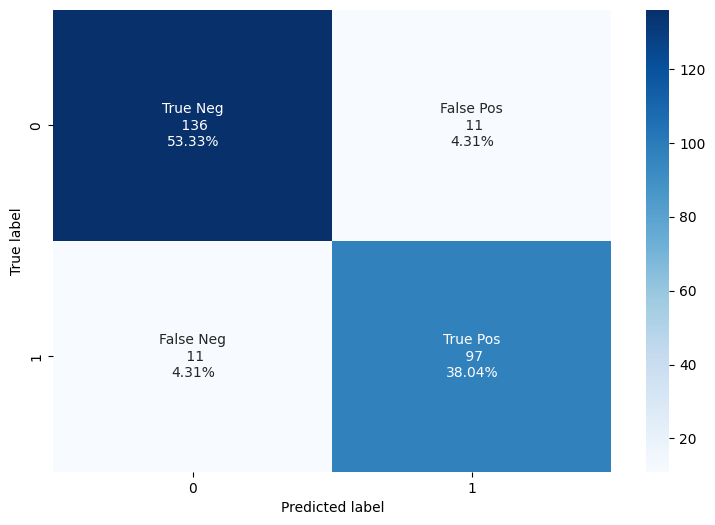

Classification report of the model for this testing set
              precision    recall  f1-score   support

           0      0.925     0.925     0.925       147
           1      0.898     0.898     0.898       108

    accuracy                          0.914       255
   macro avg      0.912     0.912     0.912       255
weighted avg      0.914     0.914     0.914       255

-------------------------------------------------------



In [26]:
lgbm_cv = lgb.cv(
    params,
    lgb.Dataset(np.vstack((X_train, X_val)),np.hstack((y_train, y_val))),
    folds=kfold,
    callbacks=[early_stopping],
    return_cvbooster=True
)
lgbm_clf_cv = lgbm_cv['cvbooster'].boosters[-1]

y_pred = lgbm_clf_cv.predict(X_test)
plot_scores(y_test, np.array([0 if x < 0.5 else 1 for x in y_pred]))

## Probability density function for `x=3`

In [27]:
N = 15000
bid_min, bid_max = X[:, 1].min(), X[:, 1].max()
# We simulate N auctions, with bids following an uniform random variable, between the min and max bids in the known data
z = uniform.rvs(loc=bid_min, scale=bid_max, size=(N, 1), random_state=random_state)
X_density3 = np.hstack((np.full((N, 1), 3), z))
# We apply box-cox transform to simulated data to predict auctions results based on our model
X_density3_transform = pt.transform(X_density3)
y_density3 = lr_clf.predict(X_density3_transform)

[]

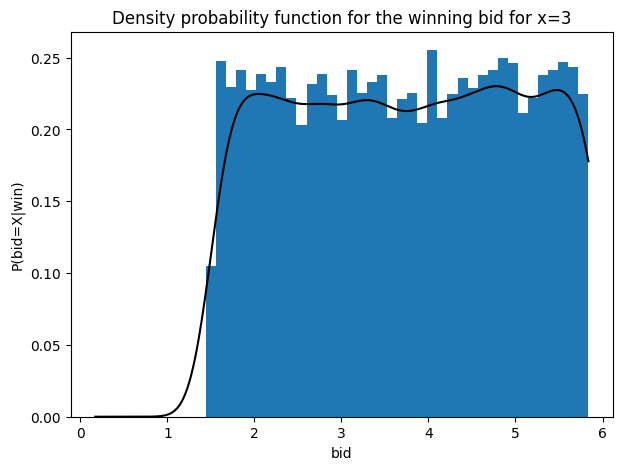

In [28]:
# We fit a gaussian kde on the input bids that have probability of winning > 0.5
density = gaussian_kde(X_density3[y_density3.astype(bool)][:, 1])
u = np.linspace(bid_min, bid_max, 500)
v = density.evaluate(u)

fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(u, v, 'k')
ax.set_xlabel("bid")
ax.set_ylabel("P(bid=X|win)")
ax.set_title("Density probability function for the winning bid for x=3")

ax.hist(
    X_density3[y_density3.astype(bool)][:, 1],
    bins=np.linspace(bid_min, bid_max, 50),
    density=True)
plt.plot()

In [29]:
print(f"P(1 <= bid <= 2 | win) \u2248 {density.integrate_box_1d(1, 2):.3%}")

P(1 <= bid <= 2 | win) ≈ 11.306%


## Cost computation

In [30]:
real_cost = np.sum(X[:, 1] * y)

We simulate `n_simulations` auctions sets, using our model to probabilities to get samples of won auctions associated to known `(x,bid)`.
We then compute the costs for each sample, and compute how many of them are higher than the real cost.

The probability of having a higher cost is obtained using the law of the large numbers.

In [31]:
n_simulations = 10000
y_pred_proba = lr_clf.predict_proba(X_transform)
samples = rgn.binomial(1, y_pred_proba[:,1], (n_simulations, n_data)).T
expected_cost_samples = np.sum(X[:, 1, None] * samples, axis=0)

In [32]:
proba_higher_cost = (expected_cost_samples >= real_cost).sum()
print(f"P(pred_costs >= real_costs) \u2248 {proba_higher_cost/n_simulations:.3%}")

P(pred_costs >= real_costs) ≈ 61.520%
